## Import packages and data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_excel('./data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


In [ ]:
data

On first overview of the data:
- Categorical variables are mostly one-hot encoded already. The exception is `AGE_PERCENTIL` and `WINDOW`. 
- The numeric variables are min-max scaled.
- There are 384 unique people identifiers.
- There are 5 missing values from disease groupings.
- Blood metrics have 1104 common missing values.
- Other biometrics have various missing values ranging from 685 to 748
- There are no missing values for `PATIENT_VISIT_IDENTIFIER`, `AGE_ABOVE65`, `AGE_PERCENTIL`, `GENDER`, `WINDOW`, and `ICU` (the target)


## Exploratory data analysis

### Numeric features

In [35]:
# numeric features for plotting
num_data = data[data.columns[data.nunique() > 2]]
num_data = num_data[num_data.columns[num_data.dtypes != 'O']]
num_data.columns

Index(['PATIENT_VISIT_IDENTIFIER', 'ALBUMIN_MEDIAN', 'ALBUMIN_MEAN',
       'ALBUMIN_MIN', 'ALBUMIN_MAX', 'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN',
       'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_VENOUS_MEDIAN',
       ...
       'HEART_RATE_DIFF', 'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF',
       'OXYGEN_SATURATION_DIFF', 'BLOODPRESSURE_DIASTOLIC_DIFF_REL',
       'BLOODPRESSURE_SISTOLIC_DIFF_REL', 'HEART_RATE_DIFF_REL',
       'RESPIRATORY_RATE_DIFF_REL', 'TEMPERATURE_DIFF_REL',
       'OXYGEN_SATURATION_DIFF_REL'],
      dtype='object', length=181)

#### Descriptive statistics

#### Distribution plots

<AxesSubplot: xlabel='PATIENT_VISIT_IDENTIFIER', ylabel='Count'>

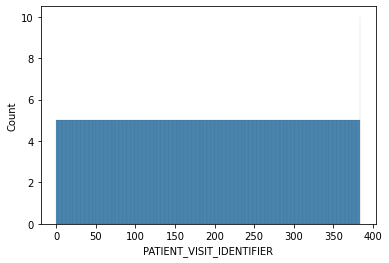

In [38]:
sns.histplot(num_data, x='PATIENT_VISIT_IDENTIFIER', binwidth=1)

Each person has 5 rows, a row for each `WINDOW` time.

In [43]:
num_data[num_data.columns[num_data.columns.str.contains('ALBUMIN')]]

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,0.605263,0.605263,0.605263,0.605263
3,NaN,NaN,NaN,NaN
4,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
1920,NaN,NaN,NaN,NaN
1921,0.605263,0.605263,0.605263,0.605263
1922,NaN,NaN,NaN,NaN
1923,NaN,NaN,NaN,NaN


### Categorical features

#### Distribution plots

#### One-hot encoding

### Collinearity and covariance plots